<a href="https://colab.research.google.com/github/yuchiahung/data-course-sample/blob/main/AC_hw2_content_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week2 (2021/12/27)

## 基礎建設

In [1]:
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [2]:
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [3]:
from tqdm import tqdm

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

## 載入資料

In [5]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

--2022-01-02 13:30:56--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv.4’

All_Beauty.csv.4    100%[===================>]  14.78M  9.47MB/s    in 1.6s    

2022-01-02 13:30:58 (9.47 MB/s) - ‘All_Beauty.csv.4’ saved [15499476/15499476]

--2022-01-02 13:30:58--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz.4’

meta_All_Beauty.jso 100%[===================>]   9.85M  7.54MB/s    in 1.3s   

In [6]:
metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [7]:
metadata.shape, ratings.shape

((32892, 19), (371345, 4))

In [8]:
metadata.head(3)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]


In [9]:
ratings.head()

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200


## 資料整理

In [10]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

In [11]:
# drop duplicates rows
metadata_clean = metadata.loc[metadata.astype(str).drop_duplicates().index]
metadata.shape, metadata_clean.shape

((32892, 19), (32488, 19))

In [12]:
# replace empty value as Nan
metadata_clean.replace('', np.nan, inplace = True)

In [13]:
# clean column `rank`
metadata_clean['rank'] = metadata_clean['rank'].str.replace('&amp;', '&')
metadata_clean['rank'].fillna('0', inplace = True)
metadata_clean['rank_category'] = [re.search('in (.*) \(', r).group(1) if r != '0' else None for r in metadata_clean['rank']]
metadata_clean['rank_num'] = [re.search('(.*) in .*', r).group(1) if r != '0' else None for r in metadata_clean['rank']]
metadata_clean['rank_num'] = metadata_clean['rank_num'].str.replace(',', '').astype(float)

In [14]:
# count `rank_category`
metadata_clean.rank_category.value_counts()

Beauty & Personal Care       32015
Grocery & Gourmet Food          37
Health & Household              21
Toys & Games                     3
Sports & Outdoors                3
Baby                             2
Clothing, Shoes & Jewelry        2
Home & Kitchen                   1
Automotive                       1
Tools & Home Improvement         1
Name: rank_category, dtype: int64

In [15]:
(metadata_clean.rank_category != 'Beauty & Personal Care').sum()/metadata_clean.shape[0]

0.014559221866535335

In [16]:
# excluding category != 'Beauty & Personal Care'
metadata_clean = metadata_clean[metadata_clean.rank_category == 'Beauty & Personal Care']

In [17]:
# convert `price` to float
metadata_clean['price'].fillna('0', inplace = True)
metadata_clean['price'] = [re.search('\$(.*)', p).group(1) if re.search('\$(.*)', p) != None else None for p in metadata_clean['price']]
metadata_clean['price'] = metadata_clean['price'].str.replace(',', '').astype(float)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [18]:
metadata_clean.describe()

,fit,tech2,price,rank_num
count,0.0,0.0,11019.000000,3.201500e+04
mean,NaN,NaN,27.942638,1.281157e+06
std,NaN,NaN,53.903673,8.052168e+05
min,NaN,NaN,0.010000,3.500000e+01
25%,NaN,NaN,8.990000,6.783310e+05
50%,NaN,NaN,15.990000,1.129923e+06
75%,NaN,NaN,29.990000,1.741006e+06
max,NaN,NaN,2149.000000,3.481442e+06


In [19]:
metadata_clean.feature.astype(str).nunique() # only 167 rows have value in `feature`

167

In [20]:
# drop useless columns
metadata_clean.drop(
    ['category', 'tech1', 'fit', 'tech2', 'date', 'similar_item', 'feature', 'main_cat', 'rank'], 
    axis = 1, 
    inplace = True
)

### Title & Description

In [21]:
# sample title
metadata_clean.title.sample(10).tolist()

['Exclusive By Pixi Energy Blush - No.3 Naturally Sunny 8g/0.28oz',
 'Africas Best Ultimate Herbal Oil 8 Ounce (235ml)',
 'AVEDA Uruku Lip Pigment Lipstick Rich Matte Earthy Rose RV$17 #31 ORELLANA SUN',
 'Tattoo Grip Steel 316L 1 Inch GV11',
 'AZBEAUTY Exfoliating Loofah Back and Body Scrubber Set for Men and Women, Green',
 'FUNOC Lady Girl Women Cute Bowknot Bow Hairband Accessory Headband Head Band Clip',
 'Pair of 16 Gauge 3/8&quot; Length 316l Surgical Steel Captive Bead Rings By Eg Gifts',
 'New Era Shine Plus Conditioner 12 oz. (Pack of 2)',
 'Serra Enzyme 80,000IU SERRAPEPTASE (90 QUAD-STRENGHT CAPSULES) **Enteric Coated Bioactive Enzymes***',
 'PDC Pmel Clear Essence Mascara 8g']

In [22]:
# join description list as string
metadata_clean['description'] = metadata_clean.description.apply(lambda x: ''.join(x))

for c in ('title', 'description'):
    # to lower case
    metadata_clean[c] = metadata_clean[c].apply(lambda x: x.lower())
    # replace &amp; as & 
    metadata_clean[c] = metadata_clean[c].str.replace('&amp;', '&')
    # replace &quot; as "
    metadata_clean[c] = metadata_clean[c].str.replace('&quot;', '"')

# clean html tag in description
metadata_clean['description_clean'] = metadata_clean.description.apply(lambda x: re.sub('<.*?>|\\n', '', x))

# remove strings in () [] & model info (i.e. number with oz, ml, cm)
metadata_clean['title_clean'] = metadata_clean.title.apply(lambda x: re.sub('\-\s.*?\s\-|\(.*?\)|\[.*?\]|\d{1,3}\.?\d{0,2}\s?(oz|z|ml|ea|g|cm|mm|fz|\-?ounce|count|ct|\"|fl\.? oz\.?|fluid ounce|x|\-?pac(k?)|\-?piece|pc(s?)|inch)|\d{1,2}\'d{0,2}|x\s?\d{1,3}|(set|pack) of \d{1,3}|colors may vary', '', x))
metadata_clean['title_clean'] = metadata_clean.title_clean.apply(lambda x: re.sub('[^\w\s]', '', x))

# title + description
metadata_clean['title_description'] = metadata_clean['title_clean'] + metadata_clean['description_clean']

In [23]:
metadata_clean.reset_index(drop = True, inplace = True)

title 內中括號的內容為型號說明，如容量、商品個數、顏色等，由於主要目的為商品本身的相似度，故此處忽略不看

In [24]:
# first 10 titles with []
[re.search('\[.*?\]', r).group(0) for r in metadata_clean['title'].values if re.search('\[.*?\]', r)][:10]

['[health and beauty]',
 '[rejoyn rvp ivp-600 bos 2000-2]',
 '[health and beauty]',
 '[songs of hope and words of encouragement for your journey to wholeness]',
 '[packaging may vary]',
 '[health and beauty]',
 '[health and beauty]',
 '[packaging may vary]',
 '[itm]',
 '[health and beauty]']

In [25]:
# first 10 titles with ()
[re.search('\(.*?\)', r).group(0) for r in metadata_clean['title'].values if re.search('\(.*?\)', r)][:10]

['(pack of 2)',
 '(moleskine non-paper)',
 '(hall of femmes)',
 '(travel size 0.5 oz/15 ml)',
 '(black)',
 '(packaging may vary)',
 '(85 g)',
 '(170 g)',
 '(pack of 15)',
 '(12 cartridges)']

## 資料切分

In [26]:
# metadata_clean.to_csv('/content/metadata_clean.csv')
# ratings.to_csv('/content/ratings.csv')

In [27]:
# metadata_clean = pd.read_csv('/content/metadata_clean.csv')
# ratings = pd.read_csv('/content/ratings.csv')

In [28]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

In [29]:
ratings_trainings.shape

(370752, 5)

In [30]:
# excluding items which do not in the `metadata_clean`
ratings_trainings = ratings_trainings.merge(metadata_clean, how = 'inner', on = 'asin').iloc[:, :5]
ratings_trainings.shape

(361021, 5)

In [31]:
ratings_trainings

,asin,reviewerID,overall,unixReviewTime,DATE
0,7414204790,A5TA1NJOC0PJ5,5.0,1457568000,2016-03-10
1,7414204790,A1TJICB7VLGQKL,5.0,1441065600,2015-09-01
2,7414204790,A80M2286B7STE,5.0,1412294400,2014-10-03
3,7414204790,A2TM2MAA8IT34U,5.0,1407369600,2014-08-07
4,7414204790,AQGWT465GTEJG,4.0,1402704000,2014-06-14
...,...,...,...,...,...
361016,B01HJ84SGM,A2FZ7C9H14T5HZ,5.0,1506988800,2017-10-03
361017,B01HJ84SGM,A1YQHF10YIMWOL,5.0,1503532800,2017-08-24
361018,B01HJ84SGM,A1IYJVHJSCR8DR,5.0,1496016000,2017-05-29
361019,B01HJ84SGM,A7WHO9ZFPHU2B,5.0,1494288000,2017-05-09


## training data EDA

In [ ]:
ratings_trainings.head()

,asin,reviewerID,overall,unixReviewTime,DATE
0,7414204790,A5TA1NJOC0PJ5,5.0,1457568000,2016-03-10
1,7414204790,A1TJICB7VLGQKL,5.0,1441065600,2015-09-01
2,7414204790,A80M2286B7STE,5.0,1412294400,2014-10-03
3,7414204790,A2TM2MAA8IT34U,5.0,1407369600,2014-08-07
4,7414204790,AQGWT465GTEJG,4.0,1402704000,2014-06-14


In [ ]:
print(f'Total # orders: {ratings_trainings.shape[0]:,}')
print(f'Total # products: {metadata.asin.nunique():,}')
print(f'Unique purchased products: {ratings_trainings.asin.nunique():,}')
print(f'Unique purchased users: {ratings_trainings.reviewerID.nunique():,}')
print(f'Time period: {ratings_trainings.DATE.min()} ~ {ratings_trainings.DATE.max()}')

Total # orders: 361,021
Total # products: 32,488
Unique purchased products: 32,009
Unique purchased users: 314,769
Time period: 2000-10-29 00:00:00 ~ 2018-08-31 00:00:00


1. 大部分商品在過去都被買過
2. 大多使用者只買過一次

In [ ]:
print(f'Duplicated orders: {ratings_trainings.duplicated().sum():,}')  
# if item_amount > 1 in one order then would be duplicated?

Duplicated orders: 9,015


### Rating

In [ ]:
# distribution of overall rating 
ratings_trainings.describe()

,overall,unixReviewTime
count,361021.000000,3.610210e+05
mean,4.104379,1.440871e+09
std,1.365611,6.928741e+07
min,1.000000,9.727776e+08
25%,4.000000,1.416010e+09
50%,5.000000,1.457136e+09
75%,5.000000,1.485648e+09
max,5.000000,1.535674e+09


In [ ]:
# Distribution of rating 
ratings_trainings.overall.value_counts()

5.0    222073
4.0     51453
1.0     38472
3.0     29072
2.0     19951
Name: overall, dtype: int64

Text(0.5, 1.0, 'Distribution of rating')

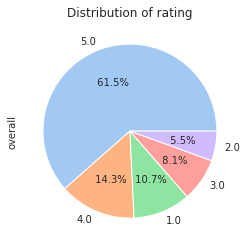

In [ ]:
colors = sns.color_palette('pastel')[:5]
ratings_trainings.overall.value_counts().plot.pie(
    y = 'overall', 
    autopct=lambda p:f'{p: .1f}%', # , \n{p*ratings_trainings.shape[0]/100 :,g}
    colors = colors 
)
plt.title('Distribution of rating')

Text(0.5, 1.0, 'Distribution of average rating')

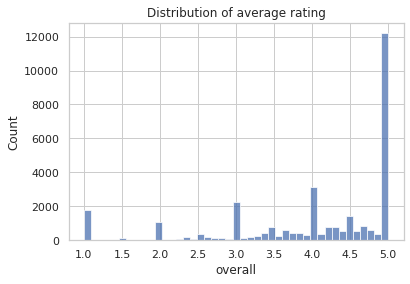

In [ ]:
# Distribution of average rating per item
items_avg_rating = ratings_trainings.groupby(by = 'asin')[['overall']].mean()
sns.histplot(data = items_avg_rating, x = 'overall')
plt.title('Distribution of average rating')

In [ ]:
print(f'{round((items_avg_rating.overall > 4).sum()*100 / items_avg_rating.shape[0], 2)}% products have average rating > 4')
print(f'{round((items_avg_rating.overall > 3).sum()*100 / items_avg_rating.shape[0], 2)}% products have average rating > 3')
print(f'{round((items_avg_rating.overall > 2.5).sum()*100 / items_avg_rating.shape[0], 2)}% products have average rating > 2.5')

57.86% products have average rating > 4
79.3% products have average rating > 3
88.04% products have average rating > 2.5


61.5% 的訂單都得到 5 顆星評價，57.9% 商品的平均評價皆 > 4   
--> 高評價的區隔性可能不大

### Order

Text(0.5, 1.0, '# order per quarter')

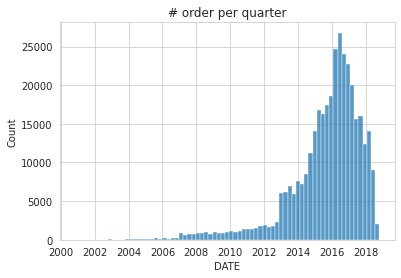

In [ ]:
# Distribution of order date
sns.histplot(data = ratings_trainings, x = 'DATE', binwidth = (90)) 
plt.title ('# order per quarter')

Text(0.5, 1.0, '# order per quarter')

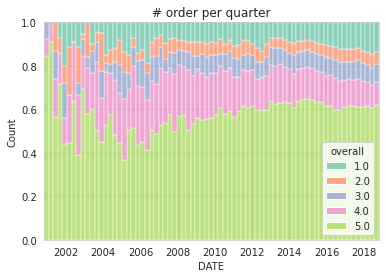

In [ ]:
# Distribution of order date & overall ratings
sns.histplot(data = ratings_trainings, x = 'DATE', hue = 'overall', 
             multiple = 'fill',
             binwidth = (90), palette = 'Set2') 
plt.title ('# order per quarter')

### Sales

In [ ]:
# Distribution of product sales 
item_purchased_count = ratings_trainings.groupby(by = 'asin')[['reviewerID']].count()
item_purchased_count.describe()

,reviewerID
count,32009.000000
mean,11.278734
std,94.291277
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,8672.000000


In [ ]:
# sales > 1 items: sales date range (max - min)
items_sold_mt1 = ratings_trainings[ratings_trainings.asin.isin(
    item_purchased_count[item_purchased_count.reviewerID > 1].index.tolist()
)]
items_sold_mt1_date = items_sold_mt1.groupby('asin')[['DATE']].agg(['max', 'min'])
items_sold_mt1_date.columns = items_sold_mt1_date.columns.droplevel(0)
items_sold_mt1_date['date_diff'] = items_sold_mt1_date['max'] - items_sold_mt1_date['min']
items_sold_mt1_date.describe()

,date_diff
count,18815
mean,708 days 02:45:32.670741424
std,728 days 15:46:05.340139136
min,0 days 00:00:00
25%,222 days 12:00:00
50%,515 days 00:00:00
75%,901 days 00:00:00
max,6245 days 00:00:00


In [ ]:
# topseller items 
topseller_items = ratings_trainings[ratings_trainings.asin.isin(
    item_purchased_count[item_purchased_count.reviewerID > 1200].index.tolist()
)]
topseller_items.asin.nunique()

16

In [ ]:
# All top 10 items 
top10_items_lst = item_purchased_count.reset_index().sort_values('reviewerID', ascending = False).head(10).asin.tolist()
top10_items = ratings_trainings[ratings_trainings.asin.isin(top10_items_lst)]
# sort by sales
top10_items = top10_items.set_index('asin').loc[top10_items_lst].reset_index()
top10_items.head()

,asin,reviewerID,overall,unixReviewTime,DATE
0,B000FOI48G,A213675GUCM3PV,1.0,1150848000,2006-06-21
1,B000FOI48G,AISWP2UHZT1S8,1.0,1150848000,2006-06-21
2,B000FOI48G,A4X295XP5LNY5,3.0,1147305600,2006-05-11
3,B000FOI48G,AJ1D427NCYOJ6,5.0,1146700800,2006-05-04
4,B000FOI48G,A39VRTC4O3SHQH,5.0,1529193600,2018-06-17


In [ ]:
# last year top 10 items 
item_purchased_count_year = ratings_trainings[ratings_trainings.DATE >= '2017-09-01'].\
    groupby(by = 'asin')[['reviewerID']].count()

top10_items_year_lst = item_purchased_count_year.reset_index().sort_values('reviewerID', ascending = False).head(10).asin.tolist()
top10_items_year = ratings_trainings[ratings_trainings.asin.isin(top10_items_year_lst)]
# sort by sales
top10_items_year = top10_items_year.set_index('asin').loc[top10_items_year_lst].reset_index()
top10_items_year.head()

,asin,reviewerID,overall,unixReviewTime,DATE
0,B01DKQAXC0,A2PSPEPE6KXP19,5.0,1442880000,2015-09-22
1,B01DKQAXC0,A5KF1QROM0DGR,5.0,1442880000,2015-09-22
2,B01DKQAXC0,A3T8QVVGBTV7SM,5.0,1442880000,2015-09-22
3,B01DKQAXC0,A1318WDRRWU8LC,5.0,1442793600,2015-09-21
4,B01DKQAXC0,A3N0UXDNWGUQ2H,5.0,1442793600,2015-09-21


In [ ]:
# last month top 10 items 
item_purchased_count_month = ratings_trainings[ratings_trainings.DATE >= '2018-08-01'].\
    groupby(by = 'asin')[['reviewerID']].count()

top10_items_month_lst = item_purchased_count_month.reset_index().sort_values('reviewerID', ascending = False).head(10).asin.tolist()
top10_items_month = ratings_trainings[ratings_trainings.asin.isin(top10_items_month_lst)]
# sort by sales
top10_items_month = top10_items_month.set_index('asin').loc[top10_items_month_lst].reset_index()
top10_items_month.head()

,asin,reviewerID,overall,unixReviewTime,DATE
0,B01DKQAXC0,A2PSPEPE6KXP19,5.0,1442880000,2015-09-22
1,B01DKQAXC0,A5KF1QROM0DGR,5.0,1442880000,2015-09-22
2,B01DKQAXC0,A3T8QVVGBTV7SM,5.0,1442880000,2015-09-22
3,B01DKQAXC0,A1318WDRRWU8LC,5.0,1442793600,2015-09-21
4,B01DKQAXC0,A3N0UXDNWGUQ2H,5.0,1442793600,2015-09-21


In [ ]:
import datetime

(730129.0, 736938.0)

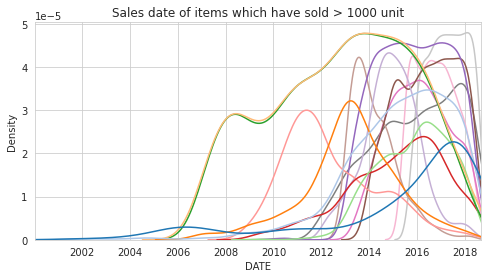

In [ ]:
fig = plt.figure(figsize = (8, 4))
sns.kdeplot(data = topseller_items.groupby(['asin', 'DATE']).count().reset_index(), 
            x = 'DATE', hue = 'asin', palette = 'tab20', 
            legend = False
)
plt.title('Sales date of items which have sold > 1000 unit')
plt.xlim(datetime.datetime(2000,1,10), datetime.datetime(2018,9,1))
# fig.savefig('/content/img/sales_dates_topseller.jpg')

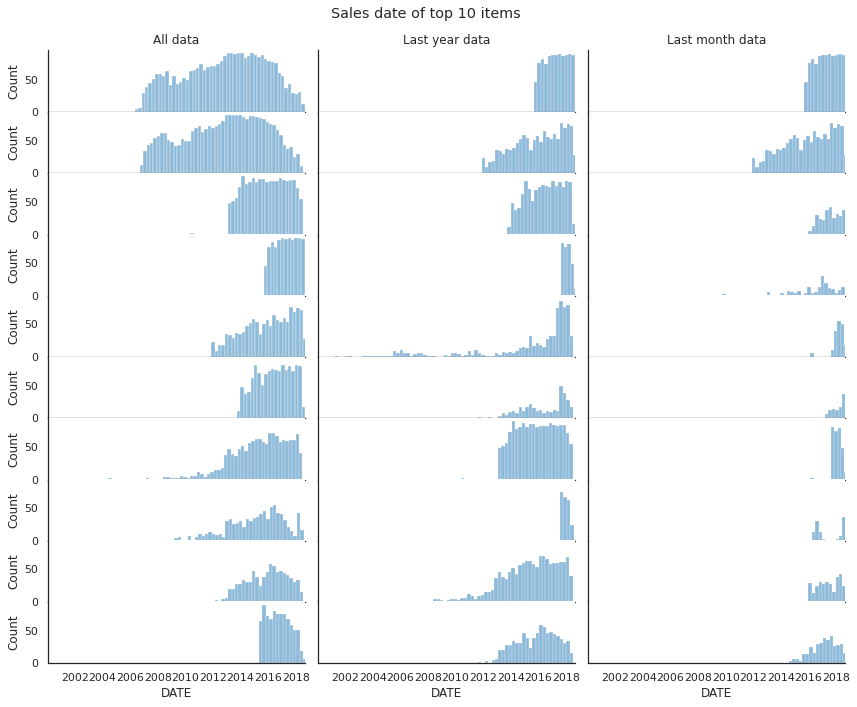

In [ ]:
sns.set_style("white")
fig, axs = plt.subplots(10, 3, sharex = True, sharey = True, figsize = (12, 10))
d = top10_items.groupby(['asin', 'DATE']).count().reset_index()
for i, a in enumerate(top10_items.asin.unique()):
    sns.histplot(data = d[d.asin == a], 
                x = 'DATE', hue = 'asin', palette = 'tab20', 
                legend = False, binwidth = (90), ax = axs[i, 0]
)

d_year = top10_items_year.groupby(['asin', 'DATE']).count().reset_index()
for i, a in enumerate(top10_items_year.asin.unique()):
    sns.histplot(data = d_year[d_year.asin == a], 
                x = 'DATE', hue = 'asin', palette = 'tab20', 
                legend = False, binwidth = (90), ax = axs[i, 1]
)

d_month = top10_items_month.groupby(['asin', 'DATE']).count().reset_index()
for i, a in enumerate(top10_items_month.asin.unique()):
    sns.histplot(data = d_month[d_month.asin == a], 
                x = 'DATE', hue = 'asin', palette = 'tab20', 
                legend = False, binwidth = (90), ax = axs[i, 2]
)

plt.tight_layout()
plt.suptitle('Sales date of top 10 items')
axs[0, 0].set_title('All data')
axs[0, 1].set_title('Last year data')
axs[0, 2].set_title('Last month data')
fig.subplots_adjust(top = 0.92, hspace=-.01)
sns.despine()

plt.xlim(datetime.datetime(2000,1,10), datetime.datetime(2018,9,1))
fig.savefig('/content/sales_date_top10_items.jpg', bbox_inches='tight')

In [ ]:
top10_items['time_period'] = 'all'
top10_items_year['time_period'] = 'year'
top10_items_month['time_period'] = 'month'
top10_items_all = pd.concat([top10_items, top10_items_year, top10_items_month], axis = 0)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


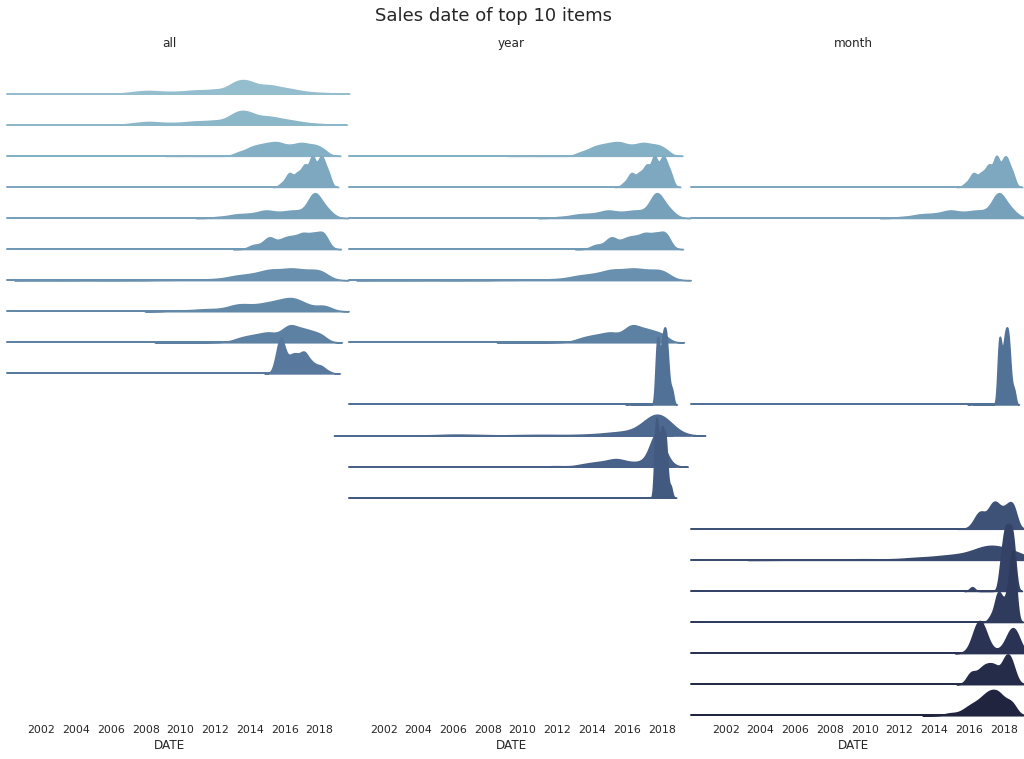

In [ ]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# 初始化網格化對象 Initialize the FacetGrid object
pal = sns.cubehelix_palette(21, rot=-.2, light=.7)
g = sns.FacetGrid(top10_items_all, row='asin', col = 'time_period', 
                  hue='asin', aspect=10, height=.5, palette=pal, 
                  xlim = [datetime.datetime(2000,1,10), datetime.datetime(2018,9,1)], 
                  ylim = [0, 0.002],
                  margin_titles = True
                  )

# 繪製密度 Draw the densities in a few steps
g.map(sns.kdeplot, 'DATE', clip_on=False, shade=True, alpha=1, lw=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# 讓子圖重疊 Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# 移除一些不必要的座標資訊 Remove axes details that don't play well with overlap
g.set_titles(col_template='{col_name}', row_template='')
g.set_ylabels('')
g.set(yticks=[])
g.despine(bottom=True, left=True)
# Title for the complete figure
plt.suptitle('Sales date of top 10 items', fontsize = 18)
  
# Adjust subplots so that titles don't overlap
g.fig.subplots_adjust(top = 0.92)
g.fig.savefig('/content/sales_date_top10_items_kde.jpg', bbox_inches='tight')

In [ ]:
# fig, axs = plt.subplots(10, 3, sharex = True, figsize = (12, 8))
# d = top10_items.groupby(['asin', 'DATE']).count().reset_index()
# for i, a in enumerate(top10_items.asin.unique()):
#     sns.kdeplot(data = d[d.asin == a], 
#                 x = 'DATE', hue = 'asin', palette = 'tab20', 
#                 legend = False, ax = axs[i, 0]
# )

# d_year = top10_items_year.groupby(['asin', 'DATE']).count().reset_index()
# for i, a in enumerate(top10_items_year.asin.unique()):
#     sns.kdeplot(data = d_year[d_year.asin == a], 
#                 x = 'DATE', hue = 'asin', palette = 'tab20', 
#                 legend = False, ax = axs[i, 1]
# )

# d_month = top10_items_month.groupby(['asin', 'DATE']).count().reset_index()
# for i, a in enumerate(top10_items_month.asin.unique()):
#     sns.kdeplot(data = d_month[d_month.asin == a], 
#                 x = 'DATE', hue = 'asin', palette = 'tab20', 
#                 legend = False, ax = axs[i, 2]
# )

# # plt.tight_layout()
# plt.suptitle('Sales date of top 10 items')
# axs[0, 0].set_title('All data')
# axs[0, 1].set_title('Last year data')
# axs[0, 2].set_title('Last month data')
# plt.xlim(datetime.datetime(2000,1,10), datetime.datetime(2018,9,1))
# # fig.savefig('/content/img/sales_date_top10_items_kde.jpg', bbox_inches='tight')

Text(0.5, 1.0, 'Distribution of sales & rank')

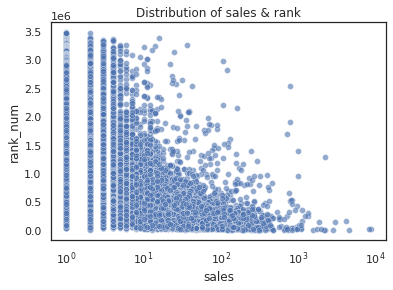

In [ ]:
# rank v.s. sales
product_sales_rating = ratings_trainings.groupby(by = 'asin')[['overall']].agg(['count', 'mean'])
product_sales_rating.columns = product_sales_rating.columns.droplevel(0)
rank_sales = product_sales_rating.reset_index().merge(metadata_clean[['asin', 'rank_num']], on = 'asin', how = 'left')
rank_sales.rename({'count': 'sales', 'mean': 'avg_rating'}, axis = 1, inplace = True)

g = sns.scatterplot(data = rank_sales, x = 'sales', y = 'rank_num', 
                    # hue = 'avg_rating',
                    alpha = 0.6)
g.set(xscale = 'log')
plt.title('Distribution of sales & rank')

排名 (rank) 前面的商品不見得銷量高，但銷量高的商品的確排名較前面。

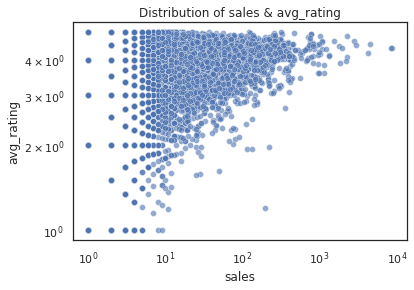

In [ ]:
# ratings v.s. sales
g = sns.scatterplot(data = rank_sales, x = 'sales', y = 'avg_rating',
                    alpha = 0.6)
g.set(xscale = 'log', yscale = 'log')
plt.title('Distribution of sales & avg_rating')
plt.savefig('test.jpg')

銷量 (Sales) 高的商品大多平均評分 (avg_rating) 不會太低，但銷量低的評分 range 就較廣

### Users

In [ ]:
# Average # items purchased per user
user_avg_items = ratings_trainings.groupby(by = 'reviewerID')[['overall']].count()
user_avg_items.describe()

,overall
count,314769.00000
mean,1.14694
std,0.50756
min,1.00000
25%,1.00000
50%,1.00000
75%,1.00000
max,26.00000


In [ ]:
print(f'{round((user_avg_items.overall == 1).sum()*100 / user_avg_items.shape[0], 2)}% buyers only purchased once')

88.74% buyers only purchased once


### Price

Text(0.5, 1.0, 'Distribution of price')

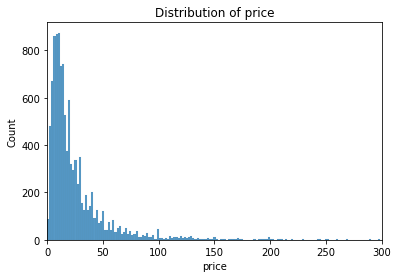

In [ ]:
# Distribution of items' price
sns.histplot(data = metadata_clean, x = 'price')
plt.xlim(0, 300)
plt.title('Distribution of price')

價格集中在 < 25 USD

In [35]:
print(f'{round((~metadata_clean.price.isna()).sum()*100 / metadata_clean.shape[0], 2)}% items have price info')


34.42% items have price info


### Brand

In [ ]:
# Distribution of # items of each brand
n_items_brand = metadata_clean.groupby('brand')[['asin']].count()
n_items_brand.describe()

,asin
count,7734.000000
mean,2.149858
std,5.107069
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,252.000000


In [ ]:
print(f'{round((n_items_brand.asin == 1).sum()*100 / n_items_brand.shape[0], 2)}% brands have only one product')
print(f'{round((n_items_brand.asin < 5).sum()*100 / n_items_brand.shape[0], 2)}% brands have < 5 products')

70.83% brands have only one product
92.5% brands have < 5 products


In [33]:
print(f'{round((~metadata_clean.brand.isna()).sum()*100 / metadata_clean.shape[0], 2)}% items have brand info')

51.93% items have brand info


### Also_view, also_buy

In [59]:
print(f'{round((metadata_clean.shape[0] - (metadata_clean.also_view == "[]").sum())*100 / metadata_clean.shape[0], 2)}% items have also_view info')

24.69% items have also_view info


In [58]:
print(f'{round((metadata_clean.shape[0] - (metadata_clean.also_buy == "[]").sum())*100 / metadata_clean.shape[0], 2)}% items have also_buy info')


20.32% items have also_buy info


### Title + Description

In [ ]:
# 計算商品用標題所表示的 tfidf 矩陣
df = metadata.drop_duplicates('title')
tf = TfidfVectorizer(analyzer='word')
tfidf_matrix = tf.fit_transform(df['title'])

In [ ]:
similarity_matrix = cosine_similarity(tfidf_matrix)

In [ ]:
mapping = pd.Series(df.index,index = df['title'])
def recommend_item(item_input, k=2):
    try:
        item_index = mapping[item_input]
        similarity_score = list(enumerate(similarity_matrix[item_index]))
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        similarity_score = similarity_score[:k] # 沒有排除自己（一定是第一名）
        item_indices = [i[0] for i in similarity_score]
        return (df['asin'].iloc[item_indices].tolist())
    except:
        return []

In [ ]:
item_input_sample = 'No7 Lift &amp; Luminate Triple Action Serum 50ml by Boots'
recommend_item(item_input_sample)

['7178680776', 'B00JZQUSLQ']

In [ ]:
mapping[item_input_sample]

1

In [ ]:
similarity_score = list(enumerate(similarity_matrix[1]))
similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
similarity_score = similarity_score[:2]
item_indices = [i[0] for i in similarity_score]

In [ ]:
similarity_score

[(1, 1.0), (13195, 0.6176525136513333)]

In [ ]:
def recommend_items(items, k):
    """input a list of items' titles """
    res = []
    for d in items:
        res.extend(recommend_item(d, k))
    return res

In [ ]:
df['title'][:5]

0        Loud 'N Clear&trade; Personal Sound Amplifier
1    No7 Lift &amp; Luminate Triple Action Serum 50...
2      No7 Stay Perfect Foundation Cool Vanilla by No7
3    Wella Koleston Perfect Hair Colour 44/44 Mediu...
4    Lacto Calamine Skin Balance Oil control 120 ml...
Name: title, dtype: object

In [ ]:
recommend_items(df['title'][:5], 2)

['6546546450',
 'B002W3172S',
 '7178680776',
 'B00JZQUSLQ',
 '7250468162',
 'B013L800JI',
 '7367905066',
 'B01BO724A6',
 '7414204790',
 'B00J7ZPHS4']

## 產生推薦 (Content-based)

### Rule1: tfidf (title) + cosine similarity

In [32]:
# 計算商品用標題所表示的 tfidf 矩陣
# df_unique_title = metadata_clean.drop_duplicates('title', ignore_index = True)
tf = TfidfVectorizer(analyzer='word')
tfidf_matrix = tf.fit_transform(metadata_clean['title'])

# 計算商品間的相似程度
similarity_matrix = cosine_similarity(tfidf_matrix)
mapping = pd.Series(metadata_clean.index,index = metadata_clean['title'])

In [33]:
metadata_clean.shape

(32015, 15)

In [34]:
# 每個商品回傳 k 個最相近的商品
def recommend_item(item_input, k, df, sim_mat):
    try:
        item_index = mapping[item_input]
        similarity_score = list(enumerate(sim_mat[item_index]))
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        similarity_score = similarity_score[:k]
        item_indices = [i[0] for i in similarity_score]
        return (df['asin'].iloc[item_indices].tolist())
    except:
        return []

# 利用使用者購買過的商品產生推薦
def recommend_items(items, k, df, sim_mat):
    res = []
    for d in items:
        res.extend(recommend_item(d, k, df, sim_mat))
    return res

In [35]:
def recommender(training_data, users, df, sim_mat, k=10):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    recommendations = {}
    '''
    content-based
    '''
    ratings_trainings = training_data
    recommendations = {user: recommend_items(df.loc[df['asin'].isin(ratings_trainings.loc[ratings_trainings['reviewerID'] == user, 'asin'].tolist()), 'title'].tolist(), k, df, sim_mat) for user in users}
    return recommendations

In [17]:
ratings_by_user_rule1 = recommender(ratings_trainings, users, df = metadata_clean, sim_mat = similarity_matrix)
ratings_by_user_rule1

{'A100XQFWKQ30O2': [],
 'A103T1QOGFCSEH': [],
 'A106UKKSJ2KXPF': [],
 'A10A7GV4D5A11V': [],
 'A1119JJ37ZLB8R': [],
 'A113UOOLBSZN52': [],
 'A12M4U7WK4ALCR': [],
 'A12T8YTW6VWT7S': [],
 'A1364JXGKB46MM': [],
 'A137DALOQFKBTI': [],
 'A13FEZ3WV7S2EY': [],
 'A13IV4I1B0RXMG': [],
 'A13JU88JAHN72I': ['B009YDVB6Q',
  'B009YDVBIE',
  'B0090BJ4UM',
  'B00UPOBQWC',
  'B01DKI7Y8O',
  'B00I8KBIB4',
  'B00IJ7ENVI',
  'B00AKAIVUG',
  'B00J1TSNZU',
  'B00BB919C2'],
 'A13K55R6VH1OOD': [],
 'A13P7VFU075A': [],
 'A13SWYE4QLB6NG': [],
 'A13ZTQ0Q4ATA41': [],
 'A142EDN04OD62U': [],
 'A142I22FIC8MZK': [],
 'A14834QTII5TLT': [],
 'A14A447VPACTBC': [],
 'A14AP6MN5XO6LB': [],
 'A14CLF25IX25US': [],
 'A14LYXC3HTBAHI': [],
 'A14VUW4KZ34EOE': [],
 'A14Y32P26G9YL': [],
 'A157T25PBS7MX4': [],
 'A15HZDSERD85C8': [],
 'A15JJ8J1FGADIX': [],
 'A15ZCL70JXXH89': [],
 'A1617KN2IAWZ6J': [],
 'A16E0O88262HKA': [],
 'A16NSZ58PTVIYF': [],
 'A16UGDXRTDLJG5': [],
 'A16X9HR3UFQQXY': [],
 'A16Y7V1CZCWKFV': ['B015ZOWER2',
  'B0183

### Rule2: tfidf (title) + Euclidean Distance

In [10]:
# 計算商品間的相似程度
similarity_matrix_euc = euclidean_distances(tfidf_matrix)

In [16]:
ratings_by_user_rule2 = recommender(ratings_trainings, users = users, df = metadata_clean, sim_mat = similarity_matrix_euc)
ratings_by_user_rule2

{'A100XQFWKQ30O2': [],
 'A103T1QOGFCSEH': [],
 'A106UKKSJ2KXPF': [],
 'A10A7GV4D5A11V': [],
 'A1119JJ37ZLB8R': [],
 'A113UOOLBSZN52': [],
 'A12M4U7WK4ALCR': [],
 'A12T8YTW6VWT7S': [],
 'A1364JXGKB46MM': [],
 'A137DALOQFKBTI': [],
 'A13FEZ3WV7S2EY': [],
 'A13IV4I1B0RXMG': [],
 'A13JU88JAHN72I': ['B00YMMOHU6',
  '6546546450',
  '7250468162',
  '7538626107',
  '8279996397',
  '8637910351',
  '8867326759',
  '889784622X',
  '8921463194',
  '8985802089'],
 'A13K55R6VH1OOD': [],
 'A13P7VFU075A': [],
 'A13SWYE4QLB6NG': [],
 'A13ZTQ0Q4ATA41': [],
 'A142EDN04OD62U': [],
 'A142I22FIC8MZK': [],
 'A14834QTII5TLT': [],
 'A14A447VPACTBC': [],
 'A14AP6MN5XO6LB': [],
 'A14CLF25IX25US': [],
 'A14LYXC3HTBAHI': [],
 'A14VUW4KZ34EOE': [],
 'A14Y32P26G9YL': [],
 'A157T25PBS7MX4': [],
 'A15HZDSERD85C8': [],
 'A15JJ8J1FGADIX': [],
 'A15ZCL70JXXH89': [],
 'A1617KN2IAWZ6J': [],
 'A16E0O88262HKA': [],
 'A16NSZ58PTVIYF': [],
 'A16UGDXRTDLJG5': [],
 'A16X9HR3UFQQXY': [],
 'A16Y7V1CZCWKFV': ['9197882747',
  'B0000

### Rule3: tfidf (title, price, brand) + cosine similarity
reference: https://towardsdatascience.com/a-content-based-recommender-for-e-commerce-web-store-7554b5b73eac 


In [20]:
metadata_clean.price.describe()

count    11019.000000
mean        27.942638
std         53.903673
min          0.010000
25%          8.990000
50%         15.990000
75%         29.990000
max       2149.000000
Name: price, dtype: float64

In [ ]:
# price
metadata_clean['price_category'] = pd.qcut(x=metadata_clean['price'], q=5, labels=[1,2,3,4,5])
metadata_clean.price_category.fillna(3, inplace = True)
price_cat_matrix = np.reciprocal(euclidean_distances(np.array(metadata_clean['price_category']).reshape(-1,1))+1)
np.save('price_cat_matrix.npy', price_cat_matrix)

In [ ]:
# brand
metadata_clean['brand_str'] = metadata_clean.brand.fillna('None')
tfidf_vectorizer = TfidfVectorizer()
brand_term = tfidf_vectorizer.fit_transform(list(metadata_clean['brand_str']))
similarity_matrix_brand = cosine_similarity(brand_term)

In [ ]:
tf = TfidfVectorizer(analyzer='word')
tfidf_matrix = tf.fit_transform(metadata_clean['title'])
similarity_matrix_title = cosine_similarity(tfidf_matrix)

In [ ]:
similarity_matrix_rule3 = price_cat_matrix * similarity_matrix_brand * similarity_matrix_title 
mapping = pd.Series(metadata_clean.index,index = metadata_clean['asin'])

In [22]:
# 每個商品回傳 k 個最相近的商品
def recommend_item(item_input, k, df, sim_mat):
    try:
        item_index = mapping[item_input]
        similarity_score = list(enumerate(sim_mat[item_index]))
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        similarity_score = similarity_score[:k]
        item_indices = [i[0] for i in similarity_score]
        return (df['asin'].iloc[item_indices].tolist())
    except:
        return []

# 利用使用者購買過的商品產生推薦
def recommend_items(items, k, df, sim_mat):
    res = []
    for d in items:
        res.extend(recommend_item(d, k, df, sim_mat))
    return res

In [20]:
def recommender(training_data, users, df, sim_mat, k=10):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    recommendations = {}
    '''
    content-based
    '''
    ratings_trainings = training_data
    recommendations = {user: recommend_items(ratings_trainings.loc[ratings_trainings['reviewerID'] == user, 'asin'].tolist(), k, df, sim_mat) for user in users}
    return recommendations

In [23]:
ratings_by_user_rule3 = recommender(ratings_trainings, users = users, df = metadata_clean, sim_mat = similarity_matrix_rule3)
# ratings_by_user_rule3

### Rule4: Sentence Transformer (title) + Cosine Similarity

In [ ]:
!pip install sentence_transformers

In [6]:
from sentence_transformers import SentenceTransformer

In [7]:
model = SentenceTransformer('all-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [17]:
sentence_embeddings = model.encode(metadata_clean['title_clean'].values)
sentence_embeddings.shape

(32015, 384)

In [18]:
similarity_matrix_transformer = cosine_similarity(sentence_embeddings)
mapping = pd.Series(metadata_clean.index,index = metadata_clean['asin'])

In [24]:
ratings_by_user_rule4 = recommender(ratings_trainings, users = users, df = metadata_clean, sim_mat = similarity_matrix_transformer)
ratings_by_user_rule4

{'A100XQFWKQ30O2': [],
 'A103T1QOGFCSEH': [],
 'A106UKKSJ2KXPF': [],
 'A10A7GV4D5A11V': [],
 'A1119JJ37ZLB8R': [],
 'A113UOOLBSZN52': [],
 'A12M4U7WK4ALCR': [],
 'A12T8YTW6VWT7S': [],
 'A1364JXGKB46MM': [],
 'A137DALOQFKBTI': [],
 'A13FEZ3WV7S2EY': [],
 'A13IV4I1B0RXMG': [],
 'A13JU88JAHN72I': ['B009YDVB6Q',
  'B009YDVBIE',
  'B00UPOBQWC',
  'B00I3Q9TNW',
  'B00OLL5LJE',
  'B015RYAGF2',
  'B017BJ7TC4',
  'B00OLL5JMS',
  'B00NB0OZ16',
  'B00RIWAJXQ'],
 'A13K55R6VH1OOD': [],
 'A13P7VFU075A': [],
 'A13SWYE4QLB6NG': [],
 'A13ZTQ0Q4ATA41': [],
 'A142EDN04OD62U': [],
 'A142I22FIC8MZK': [],
 'A14834QTII5TLT': [],
 'A14A447VPACTBC': [],
 'A14AP6MN5XO6LB': [],
 'A14CLF25IX25US': [],
 'A14LYXC3HTBAHI': [],
 'A14VUW4KZ34EOE': [],
 'A14Y32P26G9YL': [],
 'A157T25PBS7MX4': [],
 'A15HZDSERD85C8': [],
 'A15JJ8J1FGADIX': [],
 'A15ZCL70JXXH89': [],
 'A1617KN2IAWZ6J': [],
 'A16E0O88262HKA': [],
 'A16NSZ58PTVIYF': [],
 'A16UGDXRTDLJG5': [],
 'A16X9HR3UFQQXY': [],
 'A16Y7V1CZCWKFV': ['B015ZOWER2',
  'B0183

### Rule5: Rule1 + rule-based 

In [54]:
mapping = pd.Series(metadata_clean.index,index = metadata_clean['asin'])

In [55]:
def recommender(training_data, users, df, sim_mat, k=10):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    recommendations = {}

    ## Best seller (by rating data) & highest rating products (recommand `k` product)
    products_rating = training_data[training_data.DATE >= '2018-08-01'].groupby('asin')[['overall']].agg(['mean', 'count'])
    products_rating.columns = products_rating.columns.droplevel(0)
    best_seller_lst = products_rating.reset_index().sort_values(by = ['count', 'mean'], ascending = False).iloc[:k, 0].tolist()
    
    ratings_trainings = training_data
    for user in users:
        if user in ratings_trainings['reviewerID'].values: # purchased before
            recommendations[user] = recommend_items(ratings_trainings.loc[ratings_trainings['reviewerID'] == user, 'asin'].tolist(), k, df, sim_mat) 

        else:
            recommendations[user] = best_seller_lst

    return recommendations

In [56]:
ratings_by_user_rule5 = recommender(ratings_trainings, users, df = metadata_clean, sim_mat = similarity_matrix)
ratings_by_user_rule5

{'A100XQFWKQ30O2': ['B01DKQAXC0',
  'B00W259T7G',
  'B013XKHA4M',
  'B01DLR9IDI',
  'B012Z7IHHI',
  'B01AVJCDYA',
  'B0195R1FT8',
  'B01CJNZKZK',
  'B018WCT01C',
  'B01C39X6TW'],
 'A103T1QOGFCSEH': ['B01DKQAXC0',
  'B00W259T7G',
  'B013XKHA4M',
  'B01DLR9IDI',
  'B012Z7IHHI',
  'B01AVJCDYA',
  'B0195R1FT8',
  'B01CJNZKZK',
  'B018WCT01C',
  'B01C39X6TW'],
 'A106UKKSJ2KXPF': ['B01DKQAXC0',
  'B00W259T7G',
  'B013XKHA4M',
  'B01DLR9IDI',
  'B012Z7IHHI',
  'B01AVJCDYA',
  'B0195R1FT8',
  'B01CJNZKZK',
  'B018WCT01C',
  'B01C39X6TW'],
 'A10A7GV4D5A11V': ['B01DKQAXC0',
  'B00W259T7G',
  'B013XKHA4M',
  'B01DLR9IDI',
  'B012Z7IHHI',
  'B01AVJCDYA',
  'B0195R1FT8',
  'B01CJNZKZK',
  'B018WCT01C',
  'B01C39X6TW'],
 'A1119JJ37ZLB8R': ['B01DKQAXC0',
  'B00W259T7G',
  'B013XKHA4M',
  'B01DLR9IDI',
  'B012Z7IHHI',
  'B01AVJCDYA',
  'B0195R1FT8',
  'B01CJNZKZK',
  'B018WCT01C',
  'B01C39X6TW'],
 'A113UOOLBSZN52': ['B01DKQAXC0',
  'B00W259T7G',
  'B013XKHA4M',
  'B01DLR9IDI',
  'B012Z7IHHI',
  'B01A

## 結果評估

In [41]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)

    return score

In [20]:
print(f'Rule1 Score: {round(evaluate(ratings_testings_by_user, ratings_by_user_rule1), 4)}')

Rule1 Score: 0.0051


In [19]:
print(f'Rule2 Score: {round(evaluate(ratings_testings_by_user, ratings_by_user_rule2), 4)}')

Rule2 Score: 0.0


In [3]:
print(f'Rule3 Score: {round(evaluate(ratings_testings_by_user, ratings_by_user_rule3), 4)}')

Rule3 Score: 0.0


In [26]:
print(f'Rule4 Score: {round(evaluate(ratings_testings_by_user, ratings_by_user_rule4), 4)}')

Rule4 Score: 0.0034


In [60]:
print(f'Rule5 Score: {round(evaluate(ratings_testings_by_user, ratings_by_user_rule5), 4)}')

Rule5 Score: 0.1576
